# Problem Statement

While training models on large (1-100M samples) datasets, the amount of used RAM gradually increases during a single training epoch. After a few thousands of training batches, the following exception is usually raised:
```
RuntimeError: DataLoader worker (pid 31352) is killed by signal: Killed.
```
Sometimes the format of exception is a little bit different. However, a cause is always the same: the kernel kills training process because it exhausts all available system's memory, doesn't matter how many GB of RAM are available. The plot below was generated when a ResNet18 model was trained on a subset of [Quick Draw Doodle](https://www.kaggle.com/c/quickdraw-doodle-recognition/) competition dataset, with 50000 records per category, `17M = 50K * 340` samples in total. The curve clearly shows a memory leak that happens during the single training epoch.

![](./mem.png)


The goal of this notebook is to create a snippet that would help to reproduce the leakage to understand if it happens within the `fastai` library's codebase, or on `pytorch` side.

## How to reproduce

It seems that the leakage shows itself during long training periods. It is clearly seen even during a single training epoch on large dataset. Also, the memory is not deallocated even when an epoch is completed. Therefore, to reproduce, one can try to reduce the batch size, increase a number of training epochs, or do both. In other words, the number of training iterations during epoch should be relatively high (> 10000). 

The author tried to variate a large set of training conditions:


1. Using the `ImageDataBunch.create` method vs. data block API 
2. Using a custom dataset generating images on the fly agains reading them from persistent storage
3. Using different data transformations 
4. Using different versions of fastai library (1.0.22 and 1.0.28)

In every case, the `RuntimeError` exception was eventually raised.

The dataset selected in this notebook didn't allow author to _exactly_ reproduce the picture shown above. However, it still shows gradual increasing of consumed memory during epoch. The author expects that this value shouldn't increase at all as soon as the data loader's workers are spawned, and the training process is launched.

## Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from multiprocessing import cpu_count

In [3]:
from fastai import *
from fastai.vision import *
import psutil

In [5]:
device = 0

In [6]:
defaults.device = torch.device(f'cuda:{device}')

In [7]:
np.random.seed(1)

## Memory Tracking Callback

To track memory usage during training process, the `MemoryUsage` callback was created. It calls the `psutil.virtual_memory()` function on each batch end and saves returned metrics into CSV file.

In [8]:
class MemoryUsage(Callback):

    def __init__(self, memory_log: str='memory.csv'):
        self.memory_log = memory_log
        self.iter = None
        self._stream = None

    def on_train_begin(self, **kwargs):
        self.iter = 0
        if self._stream is not None:
            self.close()
        self._stream = open(self.memory_log, 'w')
        self._stream.write('index,mem_percent,mem_free,mem_available,mem_used\n')
        super().on_train_begin(**kwargs)

    def on_train_end(self, **kwargs):
        self.close()

    def on_batch_end(self, **kwargs):
        self.iter += 1
        mem = psutil.virtual_memory()
        record = [self.iter, mem.percent, mem.free, mem.available, mem.used]
        string = ','.join([str(x) for x in record])
        self._stream.write(string + '\n')
        return False

    def close(self):
        self._stream.flush()
        self._stream.close()

## Dataset

To reveal memory leak, the [The Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/). However, it could be any other dataset as soon as, presumably, the leakage happens on many machines and doesn't depend on hardware and/or dataset size, and only depends on number of training iterations.

In [9]:
path = untar_data(URLs.PETS)
path_anno = path/'annotations'
path_img = path/'images'
fnames = get_image_files(path_img)
pat = re.compile(r'/([^/]+)_\d+.jpg$')

In [10]:
# tune depending on your hardware
image_size = 1500
batch_size = 4
epochs = 10
num_workers = cpu_count()

In [11]:
data = ImageDataBunch.from_name_re(
    path_img, fnames, pat, 
    ds_tfms=get_transforms(),
    size=image_size,
    bs=batch_size, 
    num_workers=num_workers
)
_ = data.normalize(imagenet_stats)

## The Model's Training 

Originally, the issue was recorded when training `ResNet18` model from `torchvision` package. Therefore, the same setting is used here. However, presumably, it doesn't depend on the selected architecture as soon as similar `RuntimeError` exceptions were raised while training with other architectures.

In [12]:
arch = models.resnet18

In [13]:
learn = create_cnn(data, arch)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/jupyter/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 27919206.60it/s]


In [14]:
learn.fit_one_cycle(epochs, callbacks=[MemoryUsage()])

epoch,train_loss,valid_loss
1,3.276481,2.764287
2,2.836778,2.172767
3,2.629381,1.801842


KeyboardInterrupt: 

## Memory Consumption Plots


In [18]:
mem = pd.read_csv('memory.csv')
mem['mem_available'] = mem.mem_available / 1024 ** 3
mem['mem_used'] = mem.mem_used / 1024 ** 3
mem.head(4)

,index,mem_percent,mem_free,mem_available,mem_used
0,1,19.1,21205766144,25.344410,4.428032
1,2,19.0,21251350528,25.386864,4.429394
2,3,18.9,21284655104,25.417866,4.442207
3,4,18.8,21301227520,25.433239,4.470650


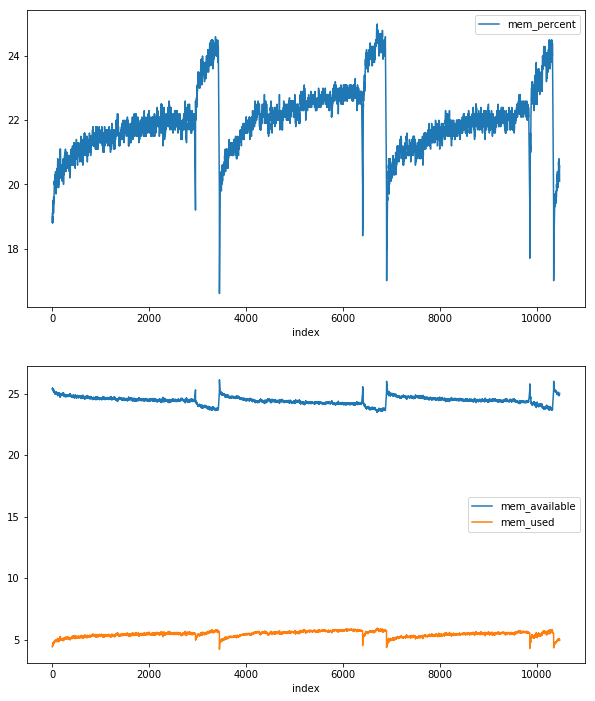

In [19]:
f, ax = plt.subplots(2, 1, figsize=(10, 12))

ax1, ax2 = ax.flat

mem.plot(x='index', y='mem_percent', ax=ax1)
mem.plot(x='index', y='mem_available', ax=ax2)
mem.plot(x='index', y='mem_used', ax=ax2)